# Chapter 11 - Singular Value Decomposition

In [1]:
import math
from book.matutil import *
from book.vecutil import *

def accept_matrix(fn):
    def wrapper(*args):
        def convert(arg):
            if isinstance(arg, Mat):
                return arg
            elif isinstance(arg, list) and isinstance(arg[0], list):
                return listlist2mat(arg)
            else:
                return arg

        args = [convert(v) for v in args]
        return fn(*args)
    return wrapper

def normV(v):
    return math.sqrt(v*v)

@accept_matrix
def normF(A):
    """calculates the Frobenius norm of matrix A."""
    rows = mat2rowdict(A).values()
    return math.sqrt(sum([r * r for r in rows]))

test_cases = [
    [
        [
            [0],
        ],
        0,
    ],
    [
        [
            [1],
        ],
        1,
    ],
    [
        [
            [3],
        ],
        3,
    ],
    [
        [
            [math.sqrt(3), math.sqrt(3), math.sqrt(3)],
        ],
        3,
    ],
    [
        [
            [1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]
        ],
        3,
    ],
    [
        [
            [1, 2],
            [3, 4],
        ],
        5.47723,
    ],
    [
        [
            [1, 4, 6],
            [7, 9, 10],
        ],
        16.8226
    ]
    
]
def assertAlmostEq(a, b, epilson=1e-5):
    assert abs(a - b) < epilson, f"{a} != {b}"

for t in test_cases:
    assertAlmostEq(normF(t[0]), t[1])

In [87]:
import random

def randOrthogonalV(D, S, eps=1e-10, max_retry = 100):
    """Generate a random unit vector orthogonal to all vectors in S."""
    c = 0
    while True:
        c += 1
        randV = list2vec([random.uniform(-1, 1) for d in D])
        # Remove the projection of randV onto all vectors in C
        for u in S:
            randV -= project_along(randV, u) 
        norm = normV(randV)
        if norm > eps:
            break
        if c > max_retry:
            return zero_vec(D)
    unit_vec = 1/norm * randV
    return unit_vec

def argmaxV(A, S=set(), samples=1e6):
    """ArgmaxV finds a vector v that maximizes |Av| using uniform random sampling method in the valid space.."""
    AV_norm = -math.inf
    v1 = None
    for _ in range(int(samples)):
        v = randOrthogonalV(A.D[1], S)
        n = normV(A*v)
        if n > AV_norm:
            AV_norm = n
            v1 = v
    return v1

def assertAlmostEqual(v, u):
    assert v.D == u.D
    assert normV((v - u) - zero_vec(v.D)) < 1e-4, f"{v} and {u} is not almost equal"

@accept_matrix
def find_right_singular_vector1(A):
    """Find A~ which minimize the Frobenius norm of A - A~.

    v is found to maximize |Av| using uniform random sampling method.
    """
    v1 = argmaxV(A)
    s = normV(A*v1)
    u = (A*v1) / s

    assertAlmostEqual(s*u, A*v1)
    return u, s, v1

A = [
    [1, 4],
    [5, 2],
]
u, s, v = find_right_singular_vector1(A)
v

Vec({0, 1},{0: -0.7776653383377226, 1: -0.6286784723116223})

In [88]:
from book.orthogonalization import project_along

def is_orthogonal(v, S, eps = 1e-4):
    """Returns whether v is orthogonal to a set of vectors"""
    return all([abs(u*v) < eps for u in S])
    
# Generalize to find k right singular vectors
@accept_matrix
def find_right_singular_vectors(A, k):
    """Find at-most k rank A~ matrix which minimize the Frobenius norm of A - A~.

    The right sigular vectors are found to maximize |Av| using uniform random sampling method.
    """
    V = []
    S = []
    U = []
    Vs = set()
    for _ in range(k):
        vi = argmaxV(A, S=Vs)
        if vi:
            Vs.add(vi)
            V.append(vi)
            S.append(normV(A*vi))
            U.append((A*vi) / s)
        else:
            break
    # assertAlmostEqual(s*u, A*v1)
    return U, S, V

A = [
    [1, 4],
    [5, 2],
]
v = find_right_singular_vectors(A, 2)
v

([Vec({0, 1},{0: -0.5389539759176704, 1: -0.8423352134647561}),
  Vec({0, 1},{0: 0.40629427455395206, 1: -0.25996152925392324})],
 [6.108831399150119, 2.946553738990281],
 [Vec({0, 1},{0: -0.7776654033848162, 1: -0.6286783918493868}),
  Vec({0, 1},{0: -0.6286783918493872, 1: 0.7776654033848159})])

In [6]:
from functools import reduce
import matplotlib.pyplot as plt
from book.svd import *
from book.eigenfaces import *
from book.image import image2display

def image2vec(l):
    """Converts a list of lists of numbers to a Vec of the same length."""
    return list2vec(reduce(lambda x, y: x + y, l, []))

def vec2image(v, width):
    """Convert vec back to a list of lists of numbers."""
    return [[v[j] for j in range(i*width, (i+1)*width)]
            for i in range(len(v.D) // width)]
    
n = 20
raw_faces = load_images("data/faces", 20)
w = len(raw_faces[0][0])
faces = {i: image2vec(raw_faces[i]) for i in raw_faces}
assert all([raw_faces[i] == vec2image(faces[i], w) for i in faces])

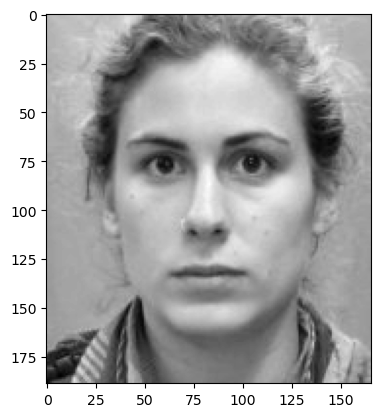

In [7]:
plt.imshow(vec2image(faces[1], w), cmap='gray')
plt.show()

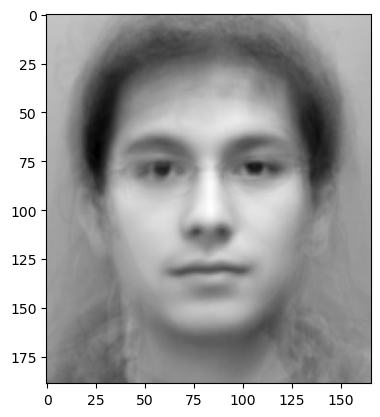

In [8]:
# Task 11.6.2, compute the centroid of the images
centroid = (1/n) * sum(faces.values())
plt.imshow(vec2image(centroid, w), cmap='gray')
plt.show()

In [9]:
# Task 11.6.3: 
A = rowdict2mat(faces)
U, S, V = factor(A)

In [10]:
# Eigenfaces are the firth 10 right singular vectors
cols = mat2coldict(V) 
eigenfaces = coldict2mat([cols[i] for i in range(10)])

In [11]:
# 11.6.4
def projected_representation(M, x):
    # x^T * M = M^T * x
    return M.transpose() * x

projected_representation(test_M, test_x)

Vec({0, 1},{0: 21.213203435596423, 1: 11.547005383792516})

In [12]:
# 11.6.5
def projection_length_squared(M, x):
    return normV(M * projected_representation(M, x))**2

projection_length_squared(test_M, test_x)

583.333333333333

In [13]:
# 11.6.6
def distance_squared(M, x):
    return normV(x - M * projected_representation(M, x))**2

distance_squared(test_M, test_x)

816.6666666666667

In [73]:
import matplotlib.pyplot as plt

def project(M, x):
    return M * projected_representation(M, x)

def detect(images, i):
    img = images[i] - centroid 
    return distance_squared(eigenfaces, img)

def display_projected(images, i):
    plt.imshow(vec2image(images[i], w), cmap='gray')
    plt.show()
    img = images[i] - centroid 
    plt.imshow(vec2image(project(eigenfaces, img) + centroid, w), cmap='gray')
    plt.show()

In [17]:
unclassified = load_images("data/unclassified", 10)
not_faces = {i: image2vec(unclassified[i]) for i in unclassified}

In [18]:
faces_result = [(i, detect(faces, i)) for i in range(20)]
unclassified_result = [(i, detect(not_faces, i)) for i in range(10)]

In [19]:
import statistics

def stats_info(numbers):
    """returns min, max, mean, median, standard deviation of a list of numbers."""
    return {
        'min': min(numbers),
        'max': max(numbers),
        'mean': sum(numbers) / len(numbers),
        'median': statistics.median(numbers),
        'stddev': statistics.stdev(numbers)
    }

In [28]:
display("Face results: ")
display(stats_info([r[1] for r in faces_result]))
display(faces_result)

display("Unclassified results: ")
display(stats_info([r[1] for r in unclassified_result]))
display(unclassified_result)

'Face results: '

{'min': 2369006.250601093,
 'max': 16670687.654201899,
 'mean': 7955952.678160545,
 'median': 7407308.703787221,
 'stddev': 3468448.0631508147}

[(0, 8769775.628695311),
 (1, 16670687.654201899),
 (2, 5941051.988740484),
 (3, 6993029.664186783),
 (4, 4391928.680231272),
 (5, 6814803.509690296),
 (6, 2369006.250601093),
 (7, 4183695.403880082),
 (8, 9705976.637189265),
 (9, 9912857.119889619),
 (10, 6515290.869329212),
 (11, 2685267.804714741),
 (12, 12511964.627601182),
 (13, 6404733.453083527),
 (14, 7203939.890096901),
 (15, 10331474.842270482),
 (16, 10700108.77833723),
 (17, 7610677.517477541),
 (18, 11659145.896966036),
 (19, 7743637.346027955)]

'Unclassified results: '

{'min': 22556914.32457643,
 'max': 103257595.73175813,
 'mean': 53224088.63468444,
 'median': 36681726.25473356,
 'stddev': 32096047.18380872}

[(0, 57862471.40112962),
 (1, 35352222.50982972),
 (2, 24765190.5028334),
 (3, 30039002.625054017),
 (4, 22556914.32457643),
 (5, 38011229.99963741),
 (6, 99113758.19482796),
 (7, 31556184.945966706),
 (8, 103257595.73175813),
 (9, 89726316.11123104)]

In [62]:
from matplotlib.patches import Rectangle

def display_grid(images, labels, num_cols=5):
    num_rows = len(images) // num_cols
    num_cols = 5
    # Create a new figure with the desired size
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 5))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # Loop through the images and add them to the plot
    for i in range(num_rows * num_cols):
        # Compute the row and column index for this image
        row_idx = i // num_cols
        col_idx = i % num_cols
        
        # Get the image and label for this index
        img = images[i]
        img = vec2image(img, w)
        label = labels[i]
        
        # Add the image to the plot
        axs[row_idx, col_idx].imshow(img, cmap='gray')
        
        # Remove the axis ticks
        axs[row_idx, col_idx].set_xticks([])
        axs[row_idx, col_idx].set_yticks([])
        
        # Add a rectangle around the image with a green or red border depending on the label
        if label:
            border_color = 'green'
        else:
            border_color = 'red'
        rect = Rectangle((0, 0), 166, 189, fill=False, edgecolor=border_color, lw=2)
        axs[row_idx, col_idx].add_patch(rect)

    # Show the plot
    plt.show()

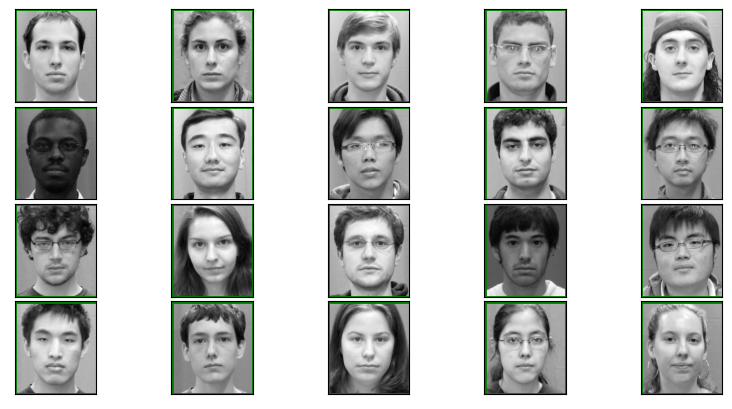

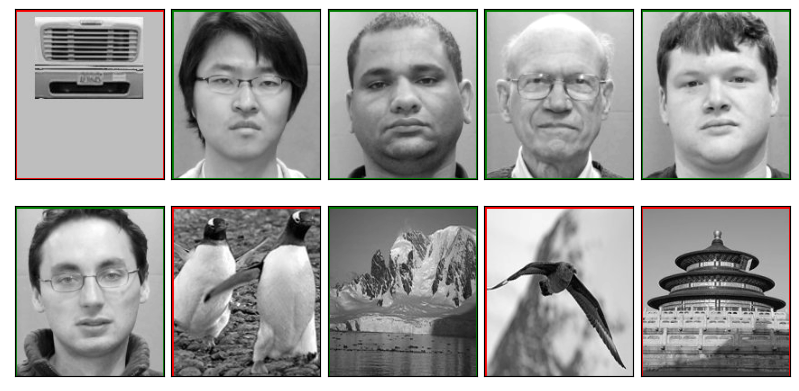

In [66]:
threshold = 5e7
face_labels = [r[1] < threshold for r in faces_result]
unclassified_labels = [r[1] < threshold for r in unclassified_result]

display_grid(faces, face_labels)
display_grid(not_faces, unclassified_labels)

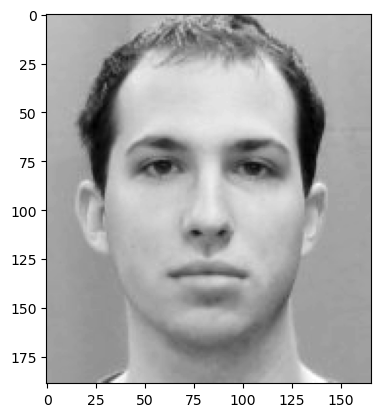

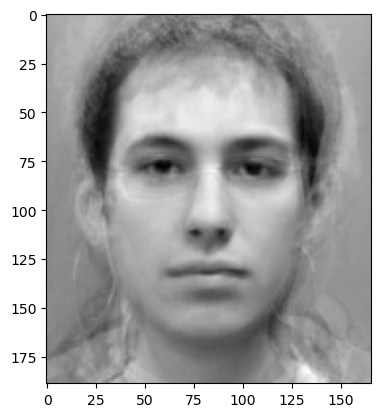

In [74]:
# Display face after projection
display_projected(faces, 0)

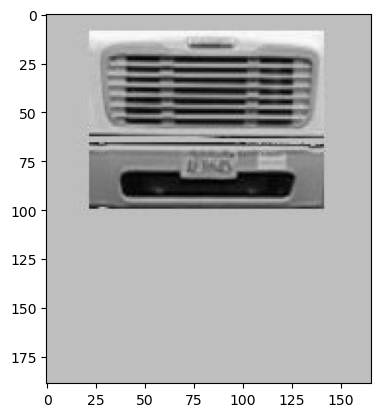

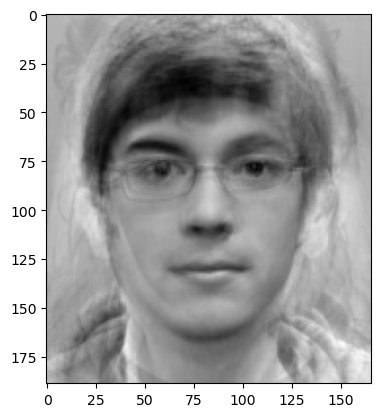

In [79]:
# Display face after projection
display_projected(not_faces, 0)

In [91]:
# Problem 11.8.1
normF([[1, 2, 3, 4], [-4, 2, -1, 0]])**2

51.00000000000001

In [115]:
# 11.8.2
import sympy
from sympy import symbols
a, b, c, d, x, y = symbols('a b c d x y')
A = sympy.Matrix([[a, b], [c, d]])
Q = sympy.Matrix([[x, 0], [0, y]])

display((A*Q).norm(), A.norm())
display((A*Q).norm() == A.norm())
# Is it only true when Q is orthonoramal?
(A*Q.subs({x: 1, y: 1})).norm() == A.subs({x: 1, y: 1}).norm()

sqrt(Abs(a*x)**2 + Abs(b*y)**2 + Abs(c*x)**2 + Abs(d*y)**2)

sqrt(Abs(a)**2 + Abs(b)**2 + Abs(c)**2 + Abs(d)**2)

False

True

In [122]:
# 11.8.3
A = [[1, 0], [0, 2], [0, 0]]
U = [[0, 1], [1, 0], [0, 0]]
S = [[2, 0], [0, 1]]
V = [[0, 1], [1, 0]]
[A, U, S, V] = [listlist2mat(L) for L in [A, U, S, V]]
x1 = list2vec([1, 2])
x2 = list2vec([2, 0])
assert A == U*S*V
[
    U*S*V*x1,
    U*S*V*x2,
]

[Vec({0, 1, 2},{0: 1, 1: 4, 2: 0}), Vec({0, 1, 2},{0: 2, 1: 0, 2: 0})]

In [135]:
# Problem 11.8.4
# A, B is full rank, diagonal, orthogonal the scaling on 
A = [[3, 0], [0, -1]]
U = [[3, 0], [0, 1]]  # preserve column
S = [[1, 0], [0, 1]]  # identity, no rotatation
V = [[1, 0], [0, -1]]
[A, U, S, V] = [listlist2mat(L) for L in [A, U, S, V]]
assert A == U*S*V
# C is rank 1, so both U,V,S is rank 1
C = [[0, 4], [0, 0], [0, 0]]
U = [[1, 0], [0, 0], [0, 0]]  # preserve column
S = [[1, 0], [0, 1]]
V = [[0, 4], [0, 0]]
[C, U, S, V] = [listlist2mat(L) for L in [C, U, S, V]]
assert C == U*S*V

In [136]:
# 11.8.5, take the first nth column in U and V

In [166]:
# 11.8.6, low ranking without SVD, TODO
# BC could be viewed as decomposition of A into rank 1 matrix bi*ci
# Make b1, b2 ... bk orthogonal; c1 contains projection of A onto b1.
# It returns if after k iteratino, the remaining A is empty
def low_rank_repr(A, k):
    Arows = mat2rowdict(A)
    D = A.D[0]
    B = set()
    C = set()
    for _ in range(k):
        bi = randOrthogonalV(D, B)
        # check bi is not zero vector
        B.add(bi)
        ci = list2vec([project_along(r, bi) for r in Arows])
        # print(ci)
        C.add(ci)
    Bm = coldict2mat(list(B))
    Cm = rowdict2mat(list(C))
    # A, Bm*Cm
    return (Bm, Cm)

A = listlist2mat([[1, 2, 3], [4, 5, 6]])
B, C = low_rank_repr(A, 2)
print(B)


           0     1
     -------------
 0  |   0.95 0.311
 1  |  0.311 -0.95

